# Requirements

In [1]:
! pip install numpy pandas torch scikit-learn yfinance matplotlib shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.9/543.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 70.1 MB/s eta 0:00:000m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 56.9 MB/s eta 0:00:00m eta 0:00:010:01m
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.0
    Uninstalling numpy-2.2.0:
      Successfully uninstalled numpy-2.2.0

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


# Data Preparation

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Define the ticker symbol
ticker_symbol = "AAPL"

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch historical market data
historical_data = ticker.history(start='1981-04-22', end='2024-12-11', interval='1d')
historical_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1981-04-22 00:00:00-05:00,0.097975,0.098405,0.097975,0.097975,18995200,0.0,0.0
1981-04-23 00:00:00-05:00,0.100553,0.100983,0.100553,0.100553,58016000,0.0,0.0
1981-04-24 00:00:00-05:00,0.100553,0.100553,0.099694,0.099694,35056000,0.0,0.0
1981-04-27 00:00:00-04:00,0.099264,0.099264,0.098834,0.098834,38528000,0.0,0.0
1981-04-28 00:00:00-04:00,0.097545,0.097545,0.097116,0.097116,32188800,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-04 00:00:00-05:00,242.869995,244.110001,241.250000,243.009995,44383900,0.0,0.0
2024-12-05 00:00:00-05:00,243.990005,244.539993,242.130005,243.039993,40033900,0.0,0.0
2024-12-06 00:00:00-05:00,242.910004,244.630005,242.080002,242.839996,36870600,0.0,0.0


In [3]:
TARGET_VAL = 'Return'

In [4]:
def calculate_features(historical_data):
    df = historical_data.copy()
    df['Return'] = df['Close'].pct_change()
    df['MA_3'] = df['Close'].rolling(window=3).mean()
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_14'] = df['Close'].rolling(window=14).mean()
    df['MA_30'] = df['Close'].rolling(window=30).mean()
    df['MA_90'] = df['Close'].rolling(window=90).mean()
    df['MA_Factor_1_3'] = (df['Close'] - df['MA_3']) / df['MA_3']
    df['MA_Factor_3_7'] = (df['MA_3'] - df['MA_7']) / df['MA_7']
    df['MA_Factor_7_14'] = (df['MA_7'] - df['MA_14']) / df['MA_14']
    df['MA_Factor_14_30'] = (df['MA_14'] - df['MA_30']) / df['MA_30']
    df['MA_Factor_30_90'] = (df['MA_30'] - df['MA_90']) / df['MA_90']
    cols = ['MA_Factor_1_3', 'MA_Factor_3_7', 'MA_Factor_7_14', 'MA_Factor_14_30', 'MA_Factor_30_90','Return']
    df = df[cols].dropna()
    return df

In [5]:
df = calculate_features(historical_data)

In [6]:
df.head()

,MA_Factor_1_3,MA_Factor_3_7,MA_Factor_7_14,MA_Factor_14_30,MA_Factor_30_90,Return
Date,,,,,,
1981-08-27 00:00:00-04:00,-0.002178,-0.038232,-0.079588,-0.066398,-0.137856,0.006579
1981-08-28 00:00:00-04:00,0.036486,-0.016879,-0.072148,-0.074534,-0.142013,0.052296
1981-08-31 00:00:00-04:00,0.016845,0.013102,-0.068540,-0.082804,-0.143749,0.000000
1981-09-01 00:00:00-04:00,0.040565,0.041971,-0.051547,-0.087512,-0.144310,0.062108
1981-09-02 00:00:00-04:00,0.031618,0.047619,-0.026770,-0.091052,-0.142902,0.017542


In [7]:
df.describe()

,MA_Factor_1_3,MA_Factor_3_7,MA_Factor_7_14,MA_Factor_14_30,MA_Factor_30_90,Return
count,10913.000000,10913.000000,10913.000000,10913.000000,10913.000000,10913.000000
mean,0.000801,0.001539,0.002596,0.005922,0.023167,0.001145
std,0.020915,0.024656,0.030149,0.047707,0.108125,0.027682
min,-0.397367,-0.396722,-0.399380,-0.458225,-0.514995,-0.518692
25%,-0.009219,-0.010931,-0.013604,-0.020023,-0.032998,-0.012499
50%,0.000950,0.001758,0.003365,0.008079,0.031790,0.000053
75%,0.010823,0.014359,0.019937,0.035022,0.091950,0.014304
max,0.199431,0.211751,0.176027,0.198848,0.377530,0.332281


<Axes: xlabel='Date'>

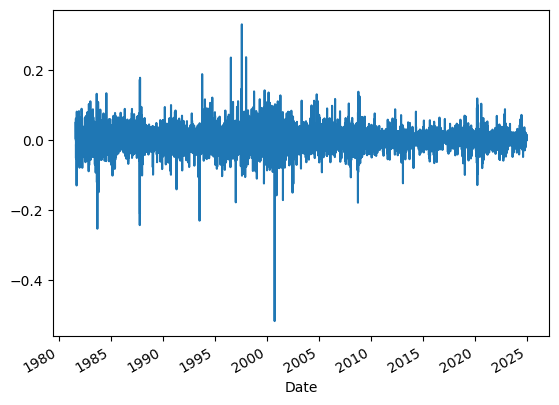

In [8]:
df.Return.plot()

<Axes: xlabel='Date'>

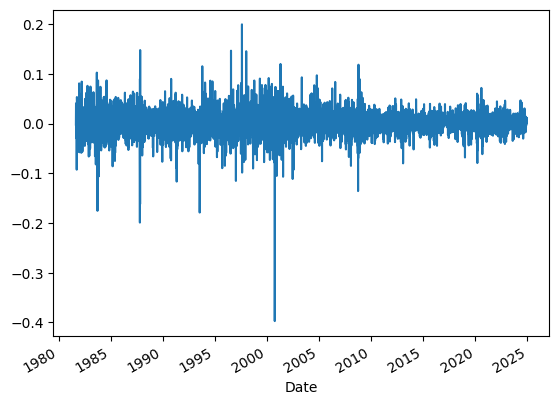

In [9]:
df.MA_Factor_1_3.plot()

<Axes: xlabel='Date'>

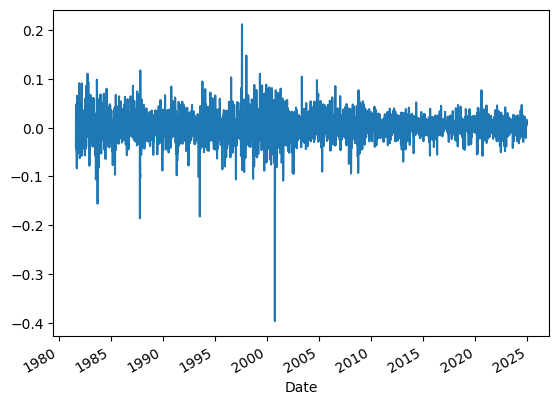

In [10]:
df.MA_Factor_3_7.plot()

<Axes: xlabel='Date'>

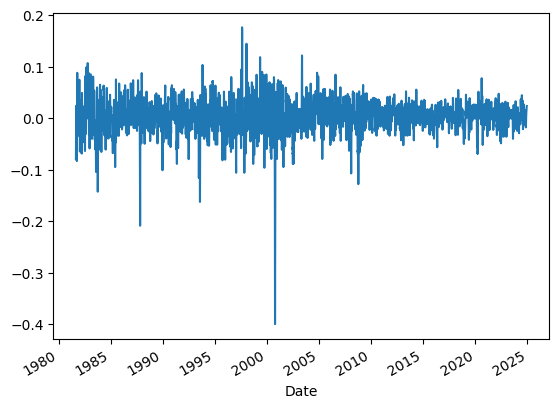

In [11]:
df.MA_Factor_7_14.plot()

<Axes: xlabel='Date'>

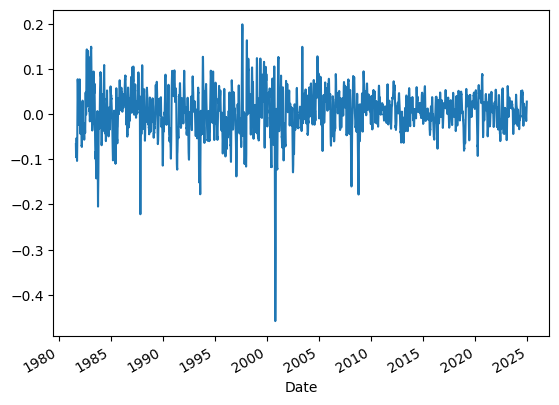

In [12]:
df.MA_Factor_14_30.plot()

<Axes: xlabel='Date'>

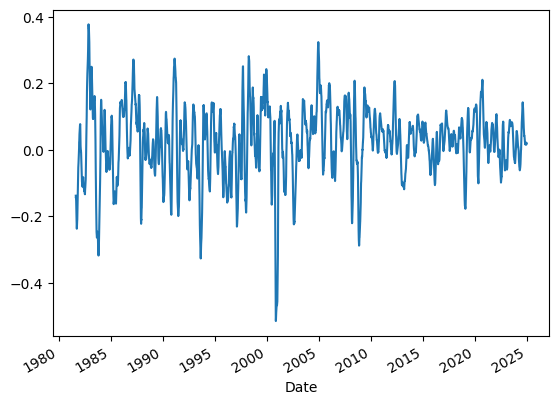

In [13]:
df.MA_Factor_30_90.plot()

In [14]:
df_over_time = df.copy()

for i in range(1, 8):
  df_over_time[f'MA_Factor_1_3_D{i}'] = df_over_time['MA_Factor_1_3'].shift(i)
  df_over_time[f'MA_Factor_3_7_D{i}'] = df_over_time['MA_Factor_3_7'].shift(i)
  df_over_time[f'MA_Factor_7_14_D{i}'] = df_over_time['MA_Factor_7_14'].shift(i)
  df_over_time[f'Return_D{i}'] = df_over_time['Return'].shift(i)

df_over_time = df_over_time.dropna()

In [15]:
df_over_time.drop(columns=[col for col in df_over_time.columns if col.startswith('MA') and len(col.split('_'))==4])\
            .corr()['Return']\
            .sort_values(key=abs, ascending=False)

Return               1.000000
MA_Factor_1_3_D2    -0.036951
Return_D3           -0.032776
MA_Factor_1_3_D4     0.027770
Return_D4            0.027119
Return_D2           -0.026545
MA_Factor_7_14_D7    0.021142
MA_Factor_7_14_D6    0.018906
MA_Factor_1_3_D3    -0.015621
MA_Factor_7_14_D5    0.012730
MA_Factor_3_7_D3     0.012721
MA_Factor_3_7_D6    -0.012082
MA_Factor_3_7_D1    -0.011534
MA_Factor_3_7_D4     0.011395
Return_D1            0.010868
MA_Factor_3_7_D7    -0.010269
MA_Factor_1_3_D5     0.009209
Return_D6            0.008380
MA_Factor_1_3_D6     0.008186
MA_Factor_7_14_D4    0.007821
Return_D5            0.005859
MA_Factor_7_14_D3    0.005367
MA_Factor_3_7_D2     0.005284
MA_Factor_3_7_D5    -0.003907
MA_Factor_1_3_D7    -0.001965
MA_Factor_7_14_D2    0.001588
MA_Factor_1_3_D1    -0.000791
Return_D7            0.000398
MA_Factor_7_14_D1   -0.000390
Name: Return, dtype: float64

In [16]:
# Splitting the data
df_train = df[:-730]
df_test = df[-730:-365]
df_backtest_train = pd.concat([df_train, df_test])
df_backtest_test = df[-365:]

In [17]:
print('Training Period:', df_train.index.min(), df_train.index.max())
print('Validation Period:', df_test.index.min(), df_test.index.max())
print('Backtest Period:', df_backtest_test.index.min(), df_backtest_test.index.max())

Training Period: 1981-08-27 00:00:00-04:00 2022-01-13 00:00:00-05:00
Validation Period: 2022-01-14 00:00:00-05:00 2023-06-29 00:00:00-04:00
Backtest Period: 2023-06-30 00:00:00-04:00 2024-12-10 00:00:00-05:00


In [18]:
def make_sequences(obs_x, obs_y, sequence_len=7, n_features=1, predicted_index=-1):
    x = []
    y = []
    for i in range(len(obs_x) - sequence_len):
        window = obs_x[i:(i + sequence_len)]
        after_window = obs_y[i + sequence_len]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, sequence_len, n_features), torch.tensor(y, dtype=torch.float32).view(-1, 1)
    

def preprocess_data(df_train, df_test, target_val, sequence_len=7, batch_size=32):
    # Scaling the features
    scaler = StandardScaler()
    
    n_features = df_train.shape[1]
    
    df_train_scaled = scaler.fit_transform(df_train)
    y_train = df_train[[target_val]].to_numpy().reshape(-1, 1)
    
    df_test_scaled = scaler.transform(df_test)
    y_test = df_test[[target_val]].to_numpy().reshape(-1, 1)
    
    # Make sequences
    x_train, y_train = make_sequences(df_train_scaled, y_train, sequence_len, n_features=df_train_scaled.shape[1])
    x_test, y_test = make_sequences(df_test_scaled, y_test, sequence_len, n_features=df_test_scaled.shape[1])
    
    # Setup data loaders for batch
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    
    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Neural Nets



In [19]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [21]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, n_encoder_layers=2, dropout=0.2):
        super().__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_encoder_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

In [22]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim=1, d_model=64, lstm_hidden_size=8, n_lstm_layers=1, dropout=0.2):
        super().__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.lstm = nn.LSTM(d_model, hidden_size=lstm_hidden_size, num_layers=n_lstm_layers)
        self.linear = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:])
        return x

In [23]:
def get_device():
    has_mps = torch.backends.mps.is_built()
    device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    return device

In [24]:
class ModelTrainer:
    def __init__(self, model,
                 criterion=nn.MSELoss(),
                 optimizer_class=torch.optim.Adam,
                 lr=0.001,
                 lr_reduce_factor=0.5,
                 lr_reduce_patience=3):
        self.device = get_device()
        self.model = model.to(self.device)
        self.criterion = criterion
        self.optimizer = optimizer_class(model.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', factor=0.5, patience=3)

    def train(self, train_loader, test_loader, epochs = 1000, early_stop_threshold=5, buy_threshold=0.005):
        early_stop_count = 0
        min_val_loss = float('inf')

        for epoch in range(epochs):
            self.model.train()
            for batch in train_loader:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(x_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()

            # Validation
            self.model.eval()
            val_losses = []
            init_amt = 100
            amt = init_amt
            with torch.no_grad():
                for batch in test_loader:
                    x_batch, y_batch = batch
                    x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)
                    outputs = self.model(x_batch)
                    loss = self.criterion(outputs, y_batch)
                    val_losses.append(loss.item())

                    for i, p in enumerate(outputs.squeeze().tolist()):
                      if p > buy_threshold:
                        amt *= (1+y_batch[i])

            val_loss = np.mean(val_losses)
            self.scheduler.step(val_loss)

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                early_stop_count = 0
            else:
                early_stop_count += 1

            if early_stop_count >= early_stop_threshold:
                print("Early stopping!")
                break
            print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.9f},", f'Return: {round(float(amt), 2)}$')

        return min_val_loss

# Strategy & Simulation Implementation

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
import datetime as dt

In [26]:
def binary_position_sizer(amt, y):
    return amt if y > 0 else 0

In [27]:
# def get_kelly_criterion_sizer(y_true, y_pred):
#     df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
#     binned_returns = df.groupby(pd.cut(df['y_pred'], bins = 10), observed=True)['y_true'].apply(list)
# 
#     binned_kelly_params = pd.DataFrame({
#         'upper_limit': binned_returns.index.to_series().apply(lambda x: x.right),
#         'returns': binned_returns
#     }).set_index('upper_limit')
#     
#     binned_kelly_params['proba_win'] = binned_kelly_params.returns.apply(lambda x: np.mean([int(r > 0) for r in x]))
#     binned_kelly_params['mean_win'] = binned_kelly_params.returns.apply(lambda x: np.mean([r for r in x if r > 0])).fillna(0.1**12)
#     binned_kelly_params['mean_loss'] = binned_kelly_params.returns.apply(lambda x: np.mean([abs(r) for r in x if r <= 0])).fillna(0.1**12)
#     binned_kelly_params['pozition_size_ratio'] = binned_kelly_params['proba_win'] / binned_kelly_params['mean_loss'] \
#                                                   + (1 - binned_kelly_params['proba_win']) / binned_kelly_params['mean_win']
#     
#     binned_kelly_params = binned_kelly_params.drop(columns='returns').to_dict(orient='index')
#     
#     def position_sizer(amt, y_pred):
#         kelly_params = None
#         last_params = None
#         
#         for upper_limit, params in binned_kelly_params.items():
#             if y_pred <= upper_limit:
#                 kelly_params = params
#                 break
#                 
#             last_params = params
# 
#         if kelly_params is None:
#             kelly_params = last_params
# 
#         position_size = amt * kelly_params['pozition_size_ratio']
#         position_size = min(max(position_size, 0), amt)
#         
#         return position_size
# 
#     return position_sizer

In [28]:
def calc_model_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'Accuracy': accuracy_score(y_true > 0, y_pred > 0),
        'Recall': recall_score(y_true > 0, y_pred > 0),
        'Precision': precision_score(y_true > 0, y_pred > 0),
        'F1': f1_score(y_true > 0, y_pred > 0)
    }

def sharpe_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate
    return np.sqrt(252) * np.mean(excess_returns) / np.std(returns)


def sortino_ratio(returns, risk_free_rate, target_return=0):
    excess_returns = returns - risk_free_rate
    downside_deviation = np.std(returns[returns < target_return])
    return np.sqrt(252) * np.mean(excess_returns) / downside_deviation

def alpha(returns, benchmark_returns, risk_free_rate):
    # Excess returns of portfolio and benchmark
    portfolio_excess = returns - risk_free_rate
    benchmark_excess = benchmark_returns - risk_free_rate

    # Calculate beta
    covariance = np.cov(portfolio_excess, benchmark_excess)[0, 1]
    benchmark_variance = np.var(benchmark_excess)
    beta = covariance / benchmark_variance

    # Calculate alpha
    expected_return = risk_free_rate + beta * (np.mean(benchmark_excess))
    alpha_value = np.mean(returns) - expected_return

    return alpha_value

def calc_portfolio_performance(returns, benchmark_returns, risk_free_rate):
    returns = np.array(returns)
    benchmark_returns = np.array(benchmark_returns)
    return {
        'Sharpe': sharpe_ratio(returns, risk_free_rate),
        'Sortino': sortino_ratio(returns, risk_free_rate),
        'Alpha': alpha(returns, benchmark_returns, risk_free_rate)
    }

In [29]:
def plot_backtest(title, prices, predictions, returns, sequence_len=7):
    price_predictions = np.array(predictions)
    returns = np.array(returns)
    
    price_predictions = prices[sequence_len:] * (1 + price_predictions)
    price_predictions.index = price_predictions.index + dt.timedelta(days=1)

    fig, ax = plt.subplots(figsize=(15, 5))
    line_predictions = ax.plot(price_predictions, color='tab:orange', label='Predicted Price')
    line_prices = ax.plot(prices, color='tab:blue', label='Actual Price')
    ax.legend(loc='upper left')

    y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
    shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

    for i, r in enumerate(returns):
        today = prices.index[i+sequence_len]
        yesterday =  prices.index[i+sequence_len-1]
        plt.axvline(yesterday, color='white', linestyle='--', alpha=0.1)
        plt.axvline(today, color='white', linestyle='--', alpha=0.1)
        color = 'tab:green' if r > 0 else 'tab:red' if r < 0 else 'white'
        plt.fill_betweenx(range(*shaded_y_lims), yesterday, today, color=color, alpha=0.4)

    plt.title(title)
    plt.ylim(*y_lims)
    plt.show()

In [30]:
DEFAULT_RISK_FREE_RATE = (1.05)**(1/365) - 1


def simulate(model, test_loader, df_test, prices, ticker_symbol, sequence_len=7, 
             position_sizer=binary_position_sizer, init_amt=100, risk_free_rate=None,
             verbose=True):
    device = get_device()
    model = model.to(device)
    prices = prices[df_test.index.min():df_test.index.max()]
    risk_free_rate = risk_free_rate if risk_free_rate else DEFAULT_RISK_FREE_RATE

    y_pred = []
    y_test = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            y_pred.extend(outputs.squeeze().tolist())
            y_test.extend(y_batch.squeeze().tolist())

    amt = init_amt
    holding = 0
    returns = []
    benchmark_returns = []
    event_list = []
    
    for i, y in enumerate(y_pred):
        next_day_idx = i + sequence_len
        today_idx = next_day_idx - 1
        
        if y > 0:
            opt_holding = position_sizer(amt+holding, y)
            diff_amt = opt_holding - holding
            amt -= diff_amt
            holding += diff_amt

            if diff_amt > 0:
                event = ('b', df_test.index[today_idx], diff_amt)
                event_list.append(event)
            elif diff_amt < 0:
                event = ('s', df_test.index[today_idx], abs(diff_amt))
                event_list.append(event)
        elif y < 0:
            event = ('s', df_test.index[today_idx], holding)
            event_list.append(event)
            amt += holding
            holding = 0

        next_day_return = df_test.iloc[next_day_idx]['Return']
        benchmark_returns.append(next_day_return)

        if holding > 0:
            returns.append(holding * next_day_return / (amt + holding))
            holding *= 1 + next_day_return
        else:
            returns.append(0)

    amt += holding
    holding = 0
    events = pd.DataFrame(event_list, columns=['Date', 'Event', 'Amount'])
    
    total_return = 100
    total_benchmark_return = 100
    for mr, br in zip(returns, benchmark_returns):
        total_return *= 1 + mr
        total_benchmark_return *= 1 + br
    
    model_metrics = calc_model_metrics(y_test, y_pred)
    portfolio_performance = calc_portfolio_performance(returns, benchmark_returns, risk_free_rate)
    ann_sharpe = np.sqrt(252) * portfolio_performance['Sharpe']
    ann_sortino = np.sqrt(252) * portfolio_performance['Sortino']
    ann_alpha = (1 + portfolio_performance['Alpha'])**252 - 1
    
    title = f'{ticker_symbol} Price Data'
    title += f'\nTotal Return: {round(total_return,2)}%, Buy & Hold: {round(total_benchmark_return, 2)}%'
    title += f"\nSharpe (Ann.): {round(ann_sharpe, 2)}, Sortino (Ann.): {round(ann_sortino, 2)}, Alpha (Ann.): {round(100*ann_alpha, 2)}%"
    title += f"\nRMSE: {round(model_metrics['RMSE'], 4)}, R2: {round(100*model_metrics['R2'], 2)}%, Acc. (Hit Rate): {round(100*model_metrics['Accuracy'], 2)}%, Recall: {round(100*model_metrics['Recall'], 2)}, Precision: {round(100*model_metrics['Precision'], 2)}"

    plot_backtest(title, prices, y_pred, returns, sequence_len=sequence_len)

    return prices, y_test, y_pred, returns, events
    

# Training

In [31]:
torch.manual_seed(0)

## LSTM

In [55]:
lstm_cols = ['MA_Factor_1_3', 'MA_Factor_3_7', 'Return']
train_loader, test_loader = preprocess_data(df_train[lstm_cols], df_test[lstm_cols], 'Return')

In [33]:
model = LSTMRegressor(input_dim=3, d_model=12, lstm_hidden_size=8, n_lstm_layers=1, dropout=0.1)
trainer = ModelTrainer(model, lr=0.001)
trainer.train(train_loader, test_loader, early_stop_threshold=5)

Using device: cpu
Epoch 1/1000, Validation Loss: 0.000424237, Return: 104.26$
Epoch 2/1000, Validation Loss: 0.000392467, Return: 123.08$
Epoch 3/1000, Validation Loss: 0.000387556, Return: 133.27$
Epoch 4/1000, Validation Loss: 0.000386204, Return: 119.52$
Epoch 5/1000, Validation Loss: 0.000383846, Return: 131.84$
Epoch 6/1000, Validation Loss: 0.000387924, Return: 120.36$
Epoch 7/1000, Validation Loss: 0.000384328, Return: 120.73$
Epoch 8/1000, Validation Loss: 0.000385481, Return: 118.22$
Epoch 9/1000, Validation Loss: 0.000384723, Return: 122.77$
Epoch 10/1000, Validation Loss: 0.000383588, Return: 115.76$
Epoch 11/1000, Validation Loss: 0.000384962, Return: 116.31$
Epoch 12/1000, Validation Loss: 0.000383956, Return: 105.83$
Epoch 13/1000, Validation Loss: 0.000385252, Return: 117.77$
Epoch 14/1000, Validation Loss: 0.000385109, Return: 113.59$
Early stopping!


np.float64(0.0003835875456085584)

In [34]:
# torch.save(model, 'stock_lstm.pt')
# torch.save(model.state_dict(), 'stock_lstm_state_dict.pt')

In [56]:
model = torch.load('models/stock_lstm.pt')

/tmp/ipykernel_389733/409919433.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_lstm.pt')


Using device: cpu


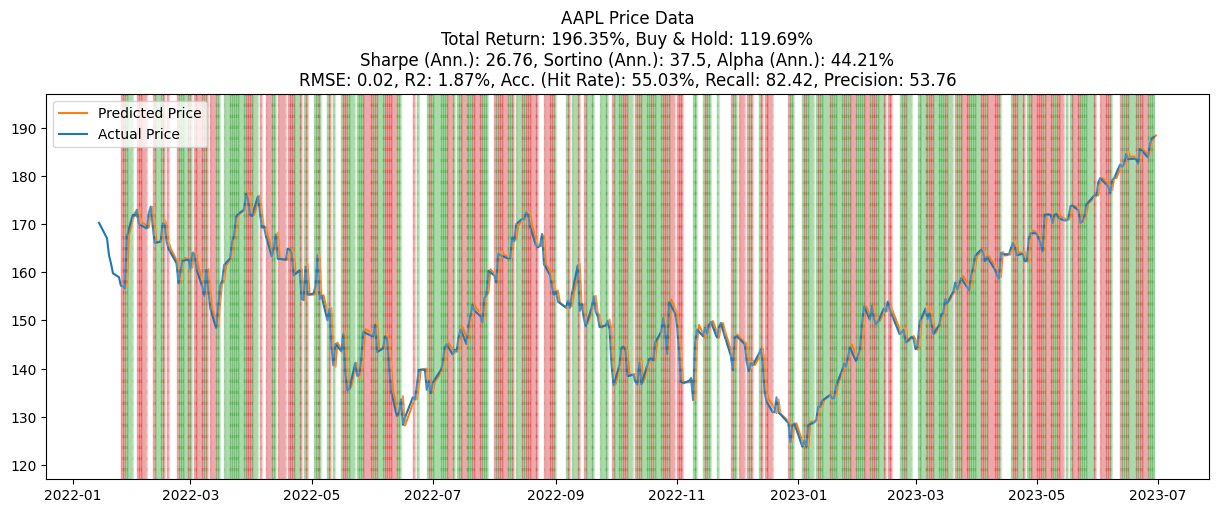

In [59]:
prices, y_test, y_pred, returns, events = simulate(model, test_loader, df_test, historical_data['Close'], ticker_symbol)

## Transformer

In [60]:
train_loader, test_loader = preprocess_data(df_train, df_test, 'Return')

In [36]:
model = TransformerRegressor(input_dim=6, d_model=8, nhead=2, n_encoder_layers=1, dropout=0.1)
trainer = ModelTrainer(model, lr=0.001)
trainer.train(train_loader, test_loader, early_stop_threshold=5)

/home/user/Git/stock_price_prediction/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Using device: cpu


/home/user/Git/stock_price_prediction/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1000, Validation Loss: 0.000411381, Return: 95.79$
Epoch 2/1000, Validation Loss: 0.000420358, Return: 114.55$
Epoch 3/1000, Validation Loss: 0.000509913, Return: 93.68$
Epoch 4/1000, Validation Loss: 0.000393469, Return: 94.24$
Epoch 5/1000, Validation Loss: 0.000402408, Return: 106.63$
Epoch 6/1000, Validation Loss: 0.000404471, Return: 101.76$
Epoch 7/1000, Validation Loss: 0.000393353, Return: 106.67$
Epoch 8/1000, Validation Loss: 0.000404160, Return: 112.44$
Epoch 9/1000, Validation Loss: 0.000403959, Return: 98.44$
Epoch 10/1000, Validation Loss: 0.000405653, Return: 100.0$
Epoch 11/1000, Validation Loss: 0.000399770, Return: 98.15$
Early stopping!


np.float64(0.0003933532370865578)

In [38]:
# torch.save(model, 'stock_transformer.pt')
# torch.save(model.state_dict(), 'stock_transformer_state_dict.pt')

In [61]:
model = torch.load('models/stock_transformer.pt')

/tmp/ipykernel_389733/1498100029.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_transformer.pt')


Using device: cpu


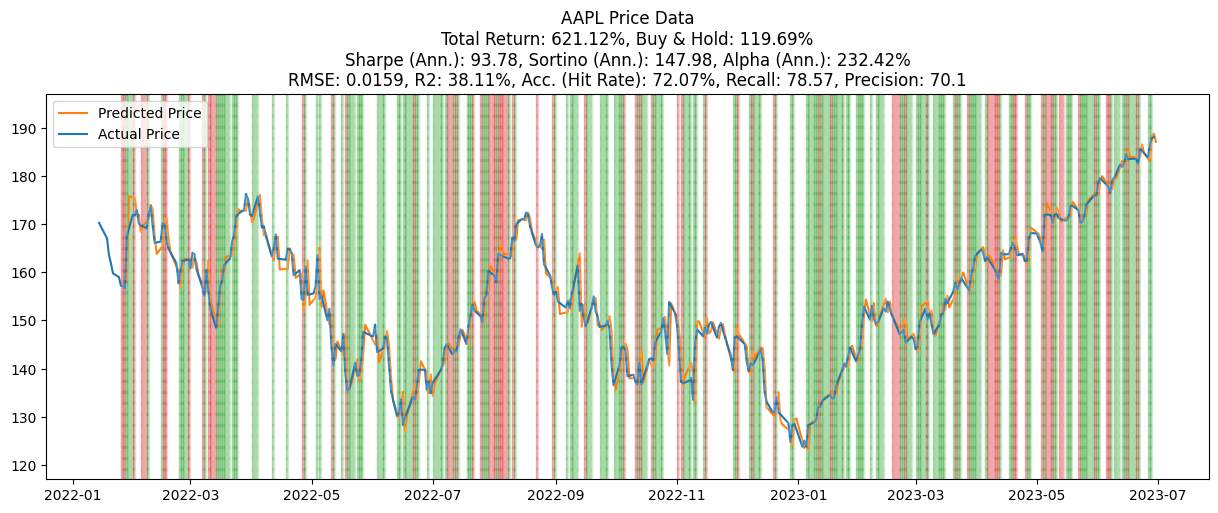

In [62]:
prices, y_test, y_pred, returns, events = simulate(model, test_loader, df_test, historical_data['Close'], ticker_symbol)

# Backtest

## LSTM

In [63]:
train_loader, test_loader = preprocess_data(df_backtest_train[lstm_cols], df_backtest_test[lstm_cols], 'Return')

In [42]:
model = torch.load('models/stock_lstm.pt')

/tmp/ipykernel_374123/409919433.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_lstm.pt')


In [179]:
trainer = ModelTrainer(model, lr=0.001)
trainer.train(train_loader, test_loader, epochs=30, early_stop_threshold=30)

Using device: cpu


/home/user/Git/stock_price_prediction/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Validation Loss: 0.000180945, Return: 99.1$
Epoch 2/30, Validation Loss: 0.000182048, Return: 100.34$
Epoch 3/30, Validation Loss: 0.000181830, Return: 99.1$
Epoch 4/30, Validation Loss: 0.000185728, Return: 99.37$
Epoch 5/30, Validation Loss: 0.000181895, Return: 100.34$
Epoch 6/30, Validation Loss: 0.000181097, Return: 100.34$
Epoch 7/30, Validation Loss: 0.000181621, Return: 100.34$
Epoch 8/30, Validation Loss: 0.000181538, Return: 100.34$
Epoch 9/30, Validation Loss: 0.000180890, Return: 99.1$
Epoch 10/30, Validation Loss: 0.000182527, Return: 100.34$
Epoch 11/30, Validation Loss: 0.000182571, Return: 100.34$
Epoch 12/30, Validation Loss: 0.000181842, Return: 100.34$
Epoch 13/30, Validation Loss: 0.000181774, Return: 100.34$
Epoch 14/30, Validation Loss: 0.000179047, Return: 100.34$
Epoch 15/30, Validation Loss: 0.000178960, Return: 100.34$
Epoch 16/30, Validation Loss: 0.000179337, Return: 100.88$
Epoch 17/30, Validation Loss: 0.000178578, Return: 100.88$
Epoch 18/30, 

np.float64(0.00017759145885065664)

In [182]:
# torch.save(model, 'stock_lstm_backtest.pt')
# torch.save(model.state_dict(), 'stock_lstm_state_dict_backtest.pt')

In [64]:
model = torch.load('models/stock_lstm_backtest.pt')

/tmp/ipykernel_389733/4160756352.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_lstm_backtest.pt')


Using device: cpu


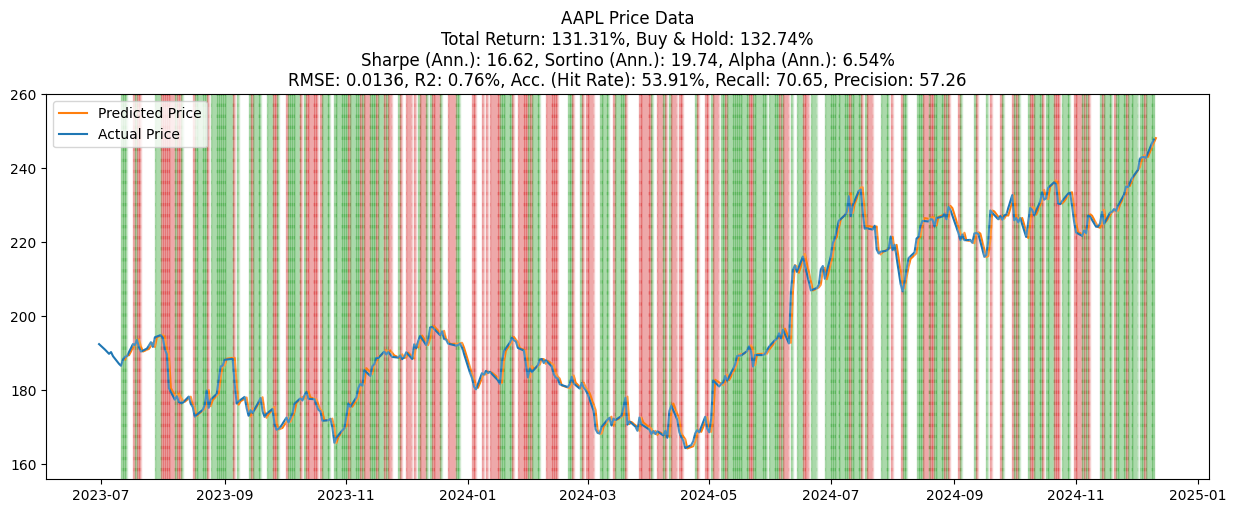

In [65]:
prices, y_test, y_pred, returns, events = simulate(model, test_loader, df_backtest_test, historical_data['Close'], ticker_symbol)

## Transformer

In [32]:
train_loader, test_loader = preprocess_data(df_backtest_train, df_backtest_test, 'Return')

/tmp/ipykernel_427397/1313451509.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(x, dtype=torch.float32).view(-1, sequence_len, n_features), torch.tensor(y, dtype=torch.float32).view(-1, 1)


In [97]:
model = torch.load('models/stock_transformer.pt')

/tmp/ipykernel_365139/1498100029.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_transformer.pt')


In [98]:
trainer = ModelTrainer(model, lr=0.001)
trainer.train(train_loader, test_loader, epochs=100, early_stop_threshold=100)

Using device: cpu


/home/user/Git/stock_price_prediction/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Validation Loss: 0.000113147, Return: 257.03$
Epoch 2/100, Validation Loss: 0.000116637, Return: 230.38$
Epoch 3/100, Validation Loss: 0.000110935, Return: 243.66$
Epoch 4/100, Validation Loss: 0.000109946, Return: 305.43$
Epoch 5/100, Validation Loss: 0.000118157, Return: 196.08$
Epoch 6/100, Validation Loss: 0.000109464, Return: 293.95$
Epoch 7/100, Validation Loss: 0.000112904, Return: 253.76$
Epoch 8/100, Validation Loss: 0.000109631, Return: 291.24$
Epoch 9/100, Validation Loss: 0.000110026, Return: 284.83$
Epoch 10/100, Validation Loss: 0.000110040, Return: 259.83$
Epoch 11/100, Validation Loss: 0.000108510, Return: 247.76$
Epoch 12/100, Validation Loss: 0.000107380, Return: 287.86$
Epoch 13/100, Validation Loss: 0.000107758, Return: 293.46$
Epoch 14/100, Validation Loss: 0.000108833, Return: 272.72$
Epoch 15/100, Validation Loss: 0.000108209, Return: 279.97$
Epoch 16/100, Validation Loss: 0.000108064, Return: 286.04$
Epoch 17/100, Validation Loss: 0.000109870, Retur

np.float64(0.00010502832363575483)

In [44]:
# torch.save(model, 'stock_transformer_backtest.pt')
# torch.save(model.state_dict(), 'stock_transformer_state_dict_backtest.pt')

In [33]:
model = torch.load('models/stock_transformer_backtest.pt')

/tmp/ipykernel_427397/3684998795.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_transformer_backtest.pt')


Using device: cpu


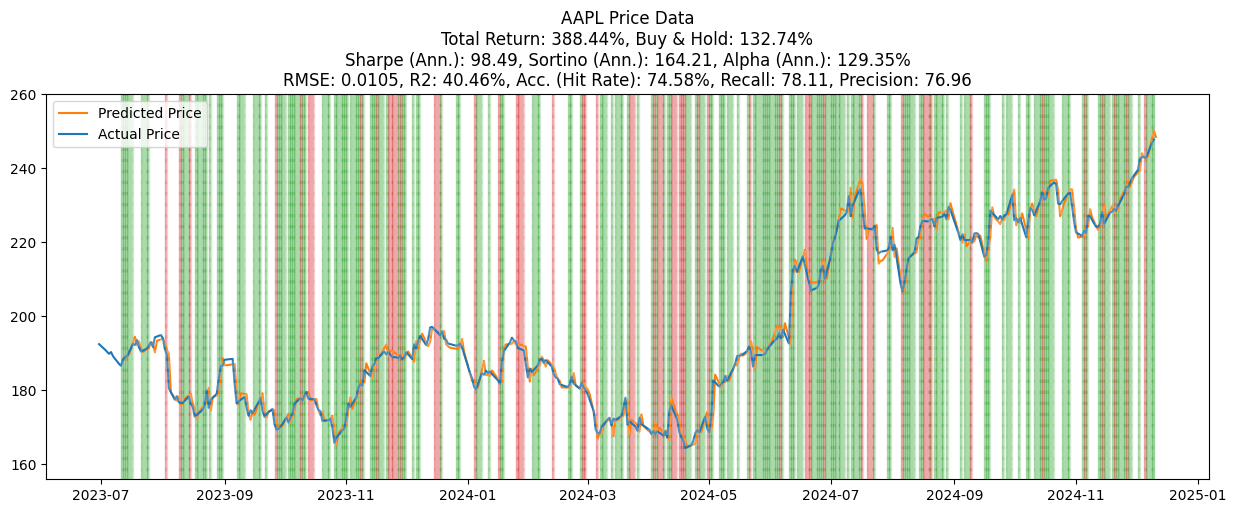

In [34]:
prices, y_test, y_pred, returns, events = simulate(model, test_loader, df_backtest_test, historical_data['Close'], ticker_symbol)

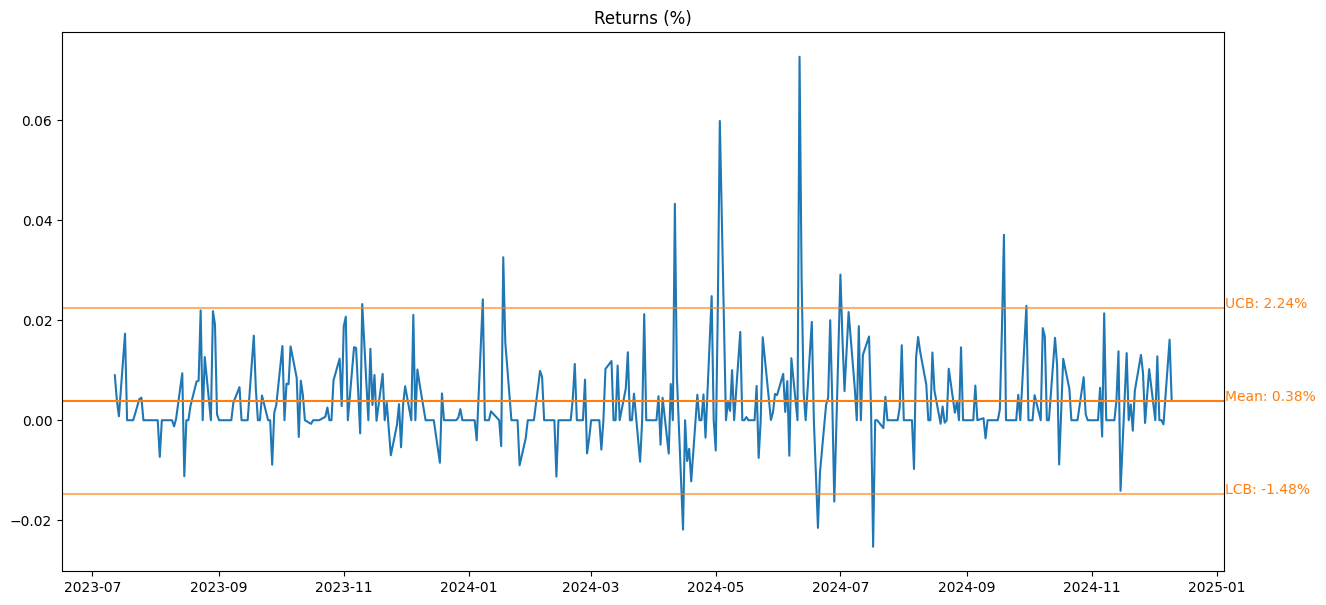

In [35]:
mean_return = np.mean(returns)
std_return = np.std(returns)
ucb = mean_return + 1.96 * std_return
lcb = mean_return - 1.96 * std_return

fig, ax = plt.subplots(figsize=(15, 7))

plt.title('Returns (%)')

plt.plot(df_backtest_test.index[7:], returns)

plt.axhline(mean_return, color='tab:orange')
ax.text(ax.get_xlim()[1] + 0.5, mean_return, f'Mean: {round(100*mean_return, 2)}%', color='tab:orange')

plt.axhline(ucb, color='tab:orange', alpha=0.6)
ax.text(ax.get_xlim()[1] + 0.5, ucb, f'UCB: {round(100*ucb, 2)}%', color='tab:orange')

plt.axhline(lcb, color='tab:orange', alpha=0.6)
ax.text(ax.get_xlim()[1] + 0.5, lcb, f'LCB: {round(100*lcb, 2)}%', color='tab:orange')

plt.show()

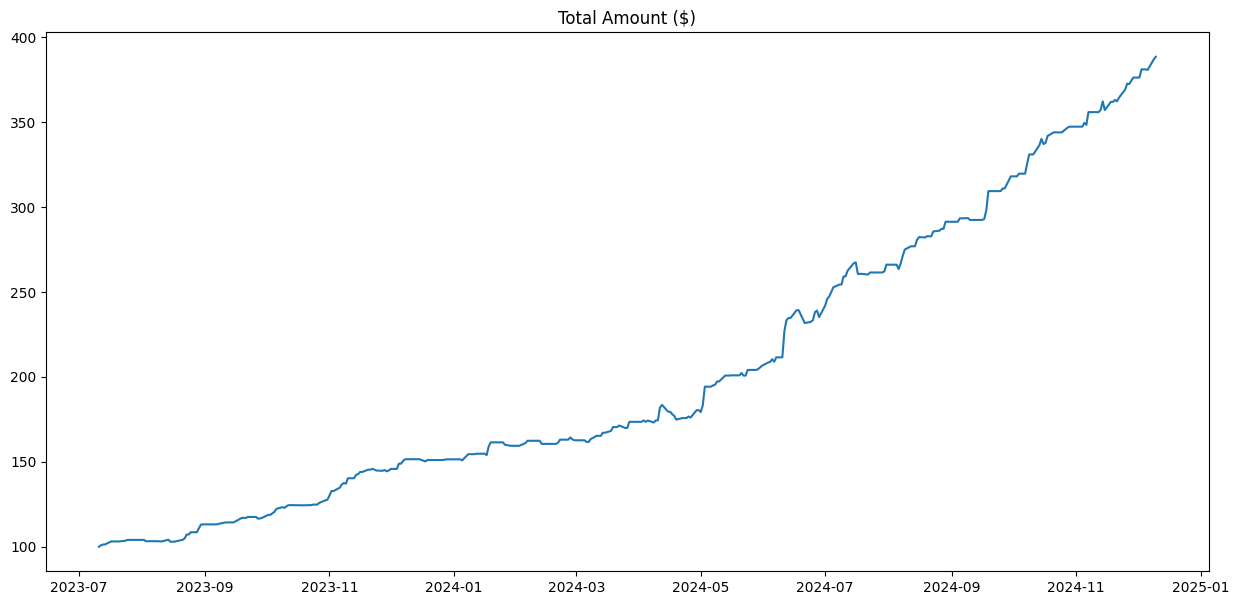

In [36]:
amts = [100]
for r in returns:
    amts.append(amts[-1]*(1+r))

plt.figure(figsize=(15, 7))
plt.title('Total Amount ($)')
plt.plot(df_backtest_test.index[6:], amts)

# Model Explanation

In [137]:
import shap
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [138]:
x_train = torch.concat([x for x, _ in train_loader])[-1000:]
y_train = torch.concat([y for _, y in train_loader])[-1000:]
x_test = torch.concat([x for x, _ in test_loader])
y_test = torch.concat([y for _, y in test_loader])

In [39]:
e = shap.GradientExplainer(model, x_train)
shap_values = e.shap_values(x_test)

In [40]:
shap_values = shap_values.reshape(shap_values.shape[0], shap_values.shape[1] * shap_values.shape[2])
shap_columns = [f'{col}_D_{i}' for i in range(7, 0, -1) for col in df_backtest_train.columns]
shap_values = pd.DataFrame(shap_values, columns=shap_columns)

In [139]:
shap_values.loc[:, shap_values.describe().loc['max']>0].describe()

,MA_Factor_1_3_D_1,MA_Factor_3_7_D_1,MA_Factor_7_14_D_1,MA_Factor_14_30_D_1,MA_Factor_30_90_D_1,Return_D_1
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,-0.000196,0.000105,-0.000381,0.000048,-0.000004,-0.000052
std,0.002529,0.000781,0.000802,0.000381,0.000086,0.009989
min,-0.009594,-0.002210,-0.003858,-0.001292,-0.000285,-0.040382
25%,-0.001606,-0.000379,-0.000812,-0.000130,-0.000047,-0.005133
50%,-0.000178,0.000061,-0.000317,0.000022,-0.000006,0.000102
75%,0.001086,0.000593,0.000066,0.000225,0.000036,0.004644
max,0.012669,0.002870,0.001949,0.001704,0.000409,0.057257


In [140]:
shap_filtered = shap_values.loc[:, shap_values.describe().loc['max']>0]
explanation_columns = shap_filtered.columns.tolist()
explanation_columns = explanation_columns + [f'{col}_contrib' for col in explanation_columns]

In [141]:
scaler = StandardScaler()
shap_scaled = scaler.fit_transform(shap_filtered)

In [142]:
explanations = np.concat([x_test[:, 6, :].numpy(), shap_scaled], axis=1)
explanations = pd.DataFrame(explanations, columns=explanation_columns)

In [163]:
k_range = list(range(2, 22))
clustering_models = []
all_clusters = []
sses = []

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    
    explanations_ = explanations.copy()
    explanations_['cluster'] = kmeans.fit_predict(explanations_)
    
    cluster_means = explanations_.groupby('cluster').mean()
    sse = 0
    for cluster in cluster_means.index:
        errors = explanations_[explanations_.cluster==cluster] - cluster_means.loc[cluster]
        sse += ((errors)**2).sum(axis=1).sum()
    
    clustering_models.append(kmeans)
    all_clusters.append(explanations_['cluster'])
    sses.append(sse)

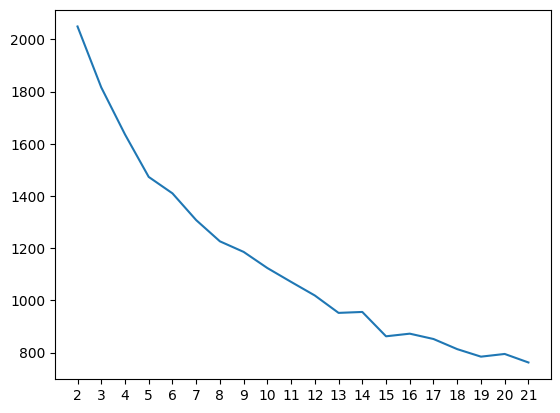

In [164]:
plt.plot(k_range, sses)
plt.xticks(k_range)
plt.show()

In [166]:
silhouette_scores = [silhouette_score(explanations, clusters) for clusters in all_clusters]

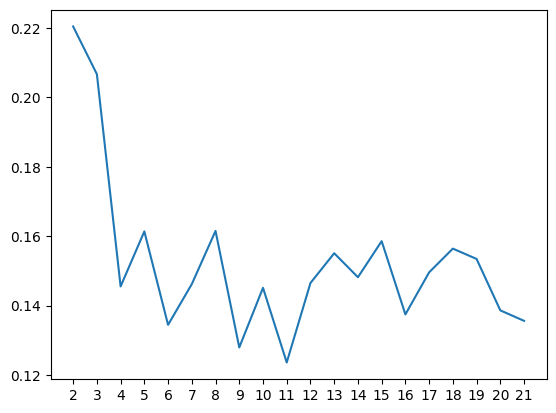

In [167]:
plt.plot(k_range, silhouette_scores)
plt.xticks(k_range)
plt.show()

In [175]:
k = 18
clusters = all_clusters[k-k_range[0]]

In [176]:
explanations_clustered = np.concat([df_backtest_test.iloc[7:], shap_filtered], axis=1)
explanations_clustered = pd.DataFrame(explanations, columns=explanation_columns)
explanations_clustered['cluster'] = clusters
explanations_clustered['y'] = y_test.reshape(y_test.shape[0])
explanations_clustered['y_pos'] = (explanations_clustered['y'] > 0).astype(int)

In [177]:
explanations_clustered.groupby('cluster')[['y', 'y_pos']]\
                      .describe()\
                      .sort_values(('y_pos', 'mean'), ascending=False)

y                                                              \
        count      mean       std       min       25%       50%       75%   
cluster                                                                     
12       28.0  0.002218  0.011913 -0.035793 -0.001273  0.002452  0.009101   
15       44.0  0.002169  0.010836 -0.028754 -0.003745  0.002555  0.008935   
13        8.0  0.002857  0.016224 -0.020535 -0.009075  0.001856  0.013935   
0        26.0  0.004410  0.014359 -0.025381 -0.006512  0.004650  0.008020   
2        58.0  0.001337  0.015506 -0.048020 -0.006476  0.003364  0.007598   
16       12.0 -0.001851  0.014073 -0.025296 -0.012302  0.002783  0.005993   
11        7.0 -0.000829  0.009796 -0.014555 -0.008080  0.001778  0.006105   
1        23.0  0.000520  0.012077 -0.023398 -0.007198  0.000581  0.006239   
4        16.0  0.001343  0.023566 -0.040857 -0.012487  0.003529  0.014515   
3        41.0  0.002466  0.009063 -0.019148 -0.003438  0.002745  0.008463   
17       13.0  0.003107  0.015429 -0.029142 -0.002927  0.000758  0.011025   
5         2.0  0.009736  0.026647 -0.009107  0.000315  0.009736  0.019157   
8        14.0  0.001428  0.010166 -0.012700 -0.004031 -0.000186  0.007915   
6        30.0 -0.002294  0.016357 -0.048167 -0.011241 -0.001704  0.007181   
14       15.0 -0.002512  0.011809 -0.029249 -0.006555 -0.000823  0.003006   
10       14.0 -0.004821  0.011574 -0.024606 -0.012182 -0.005428  0.003614   
7         3.0 -0.009670  0.017192 -0.028441 -0.017160 -0.005878 -0.000284   
9         4.0 -0.009823  0.005350 -0.017254 -0.011625 -0.008618 -0.006817   

                  y_pos                                                 
              max count      mean       std  min   25%  50%   75%  max  
cluster                                                                 
12       0.023220  28.0  0.678571  0.475595  0.0  0.00  1.0  1.00  1.0  
15       0.021372  44.0  0.659091  0.479495  0.0  0.00  1.0  1.00  1.0  
13       0.029105   8.0  0.625000  0.517549  0.0  0.00  1.0  1.00  1.0  
0        0.043271  26.0  0.615385  0.496139  0.0  0.00  1.0  1.00  1.0  
2        0.072649  58.0  0.603448  0.493454  0.0  0.00  1.0  1.00  1.0  
16       0.016743  12.0  0.583333  0.514929  0.0  0.00  1.0  1.00  1.0  
11       0.010927   7.0  0.571429  0.534522  0.0  0.00  1.0  1.00  1.0  
1        0.021949  23.0  0.565217  0.506870  0.0  0.00  1.0  1.00  1.0  
4        0.059816  16.0  0.562500  0.512348  0.0  0.00  1.0  1.00  1.0  
3        0.021620  41.0  0.560976  0.502433  0.0  0.00  1.0  1.00  1.0  
17       0.037066  13.0  0.538462  0.518875  0.0  0.00  1.0  1.00  1.0  
5        0.028578   2.0  0.500000  0.707107  0.0  0.25  0.5  0.75  1.0  
8        0.024175  14.0  0.500000  0.518875  0.0  0.00  0.5  1.00  1.0  
6        0.024808  30.0  0.466667  0.507416  0.0  0.00  0.0  1.00  1.0  
14       0.018404  15.0  0.400000  0.507093  0.0  0.00  0.0  1.00  1.0  
10       0.016480  14.0  0.357143  0.497245  0.0  0.00  0.0  1.00  1.0  
7        0.005310   3.0  0.333333  0.577350  0.0  0.00  0.0  0.50  1.0  
9       -0.004805   4.0  0.000000  0.000000  0.0  0.00  0.0  0.00  0.0

In [178]:
explanations_clustered.mean()

MA_Factor_1_3_D_1             -2.060444e-03
MA_Factor_3_7_D_1             -6.209914e-03
MA_Factor_7_14_D_1            -1.093891e-02
MA_Factor_14_30_D_1           -1.923047e-02
MA_Factor_30_90_D_1            1.168110e-02
Return_D_1                    -1.035706e-02
MA_Factor_1_3_D_1_contrib     -3.101182e-17
MA_Factor_3_7_D_1_contrib      1.026491e-16
MA_Factor_7_14_D_1_contrib     1.221866e-16
MA_Factor_14_30_D_1_contrib    1.153640e-16
MA_Factor_30_90_D_1_contrib    6.202363e-18
Return_D_1_contrib             4.341654e-17
cluster                        7.332402e+00
y                              8.845255e-04
y_pos                          5.614525e-01
dtype: float64

In [188]:
for cluster in explanations_clustered.cluster.sort_values().unique():
    print('\nCluster:', cluster, '\n')
    mean_diff_ratio = (explanations_clustered[explanations_clustered.cluster==cluster].mean() - explanations_clustered.mean()) / explanations_clustered.mean()
    mean_diff_ratio = mean_diff_ratio.to_frame(name='mean_diff_ratio')
    cluster_std_ratio = explanations_clustered[explanations_clustered.cluster==cluster].std() / explanations_clustered.mean().abs()
    cluster_std_ratio = cluster_std_ratio.to_frame(name='cluster_std_ratio')
    mean_diff_ratio = mean_diff_ratio.join(cluster_std_ratio, rsuffix='_Std_Ratio')
    print(mean_diff_ratio)


Cluster: 0 

                             mean_diff_ratio  cluster_std_ratio
MA_Factor_1_3_D_1               1.429637e+02       9.663113e+01
MA_Factor_3_7_D_1               2.748659e+01       3.967275e+01
MA_Factor_7_14_D_1              2.462836e+01       2.233440e+01
MA_Factor_14_30_D_1             2.572509e+01       9.379742e+00
MA_Factor_30_90_D_1            -3.236273e+01       2.727199e+01
Return_D_1                      2.894030e+01       2.328655e+01
MA_Factor_1_3_D_1_contrib       1.564304e+16       1.200842e+16
MA_Factor_3_7_D_1_contrib       2.518174e+15       4.618480e+15
MA_Factor_7_14_D_1_contrib     -3.447429e+15       3.643739e+15
MA_Factor_14_30_D_1_contrib     1.243314e+16       5.400745e+15
MA_Factor_30_90_D_1_contrib    -1.209468e+17       8.982065e+16
Return_D_1_contrib             -1.260755e+16       1.076811e+16
cluster                        -1.000000e+00       0.000000e+00
y                               3.985311e+00       1.623365e+01
y_pos                     

In [180]:
explanations_clustered

,MA_Factor_1_3_D_1,MA_Factor_3_7_D_1,MA_Factor_7_14_D_1,MA_Factor_14_30_D_1,MA_Factor_30_90_D_1,Return_D_1,MA_Factor_1_3_D_1_contrib,MA_Factor_3_7_D_1_contrib,MA_Factor_7_14_D_1_contrib,MA_Factor_14_30_D_1_contrib,MA_Factor_30_90_D_1_contrib,Return_D_1_contrib,cluster,y,y_pos
0,-0.298306,-0.453567,0.250603,0.357470,0.546849,-0.141416,-0.528765,0.791190,0.707358,-1.161965,0.962121,-0.261613,2,0.008986,1
1,0.199635,-0.392378,0.074386,0.349196,0.544064,0.279228,0.438489,0.579321,0.232864,-0.314236,-0.400776,0.477422,15,0.004057,1
2,0.230380,-0.199501,-0.016843,0.327078,0.542123,0.103480,0.507526,0.376179,-0.077777,-0.195329,-0.125457,0.203014,15,0.000787,1
3,0.050582,0.003116,-0.082088,0.308040,0.542234,-0.013130,0.563532,-0.090244,-0.293770,-0.321120,0.404395,0.204928,6,0.017306,1
4,0.516089,0.233525,-0.135613,0.324654,0.539638,0.575934,0.845897,-0.481925,0.014219,0.109251,-1.419197,1.070811,16,-0.001340,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,0.511890,0.585532,0.522024,0.074045,-0.057574,0.414250,0.944440,-1.449330,0.808920,-0.471684,0.502703,0.821401,12,0.001484,1
354,0.208165,0.583151,0.602938,0.166620,-0.059126,0.011699,0.527419,-0.918914,1.224512,-0.442554,-0.174233,0.058350,12,0.000123,1
355,-0.010672,0.528552,0.655002,0.223666,-0.053544,-0.036806,-0.041701,-0.869306,1.122590,-0.368663,-0.470494,-0.088669,12,-0.000823,0
356,-0.061844,0.351231,0.628328,0.299881,-0.046407,-0.070554,-0.138139,-0.590047,1.100586,-0.563369,-0.433445,-0.092402,2,0.016101,1
